# Одномерная линейная регрессия. Метод градиентного спуска

Линейная регрессия (англ. linear regression) — метод восстановления зависимости одной (объясняемой, зависимой) переменной  𝑦  от другой или нескольких других переменных (факторов, регрессоров, независимых переменных)  𝑥  с линейной функцией зависимости:

𝑦=𝜃0+𝜃1×𝑥1+𝜃2×𝑥2+...+𝜃𝑚×𝑥𝑚 

Задача заключается в поиске такого набора параметров  𝜃 , чтобы получать как можно лучшие результаты в предсказании  𝑦 . В этом задании мы будем рассмотривать метод градиентного спуска для подбора параметров  𝜃  (существуют и другие методы, например, метод наименьших квадратов).

Описание набора данных взято из курса Н.Ю.Золотых.

В качестве набора данных мы будем использовать The Boston Housing Dataset. База содержит информацию о загородных домах близ Бостона, собранную службой переписи населения США. Данные были собраны в 1970-х годах. Информация агрегирована: территория поделена на участки и дома, стоящие на одном участке, собраны в группы. Нужно оценить среднюю цену дома. Таким образом, объектами являются сами эти группы. Их общее количество — 506. В качестве признаков рассматриваются:

- CRIM — уровень преступности на душу населения;
- ZN — процент земли, застроенной жилыми домами (только для участков площадью свыше 25000 кв. - футов);
- INDUS — процент деловой застройки;
- CHAS — 1, если участок граничит с рекой; 0 в противном случае (бинарный признак);
- NOX — концентрация оксида азота, деленная на 10^7;
- RM — среднее число комнат (по всем домам рассматриваемого участка);
- AGE — процент домов, построенных до 1940 г. и занимаемых владельцами;
- DIS — взвешенное расстояние до 5 деловых центров Бостона;
- RAD — индекс удаленности до радиальных магистралей;
- TAX — величина налога в $10000;
- PTRATIO — количество учащихся, приходящихся на одного учителя (по городу);
- B = 1000(AA − 0.63)^2, где AA — доля афро-американцев;
- LSTAT — процент жителей с низким социальным статусом. Признак CHAS — бинарный, остальные — количественные. Выходом является переменная MEDV, равная медианному значению цены строения (по всем домам участка) в $1000.

In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
import sklearn

In [6]:
from sklearn.datasets import load_boston
boston = load_boston()

In [7]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [8]:
data = pd.DataFrame(data=boston.data, columns=boston.feature_names)
data["MEDV"] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Есть ли в данных пропуски?

In [9]:
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Мы начнем с построения простой линейной модели с одной переменной. Переменную выберем по значению коэффициента корреляции Пирсона с целевым признаком MEDV:

In [10]:
pearson = data.corr(method="pearson")
pearson["MEDV"].drop("MEDV").sort_values(ascending=False)

RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

Наиболее высокий коэффициент корреляции у двух переменных: RM (среднее число комнат) и LSTAT (процент жителей с низким социальным статусом). Выберем переменную RM для объяснения MEDV.

Давайте построим диаграмму рассеяния и визуально оценим взаимосвязь между средним числом комнат на участке и средней ценой дома на этом участке:

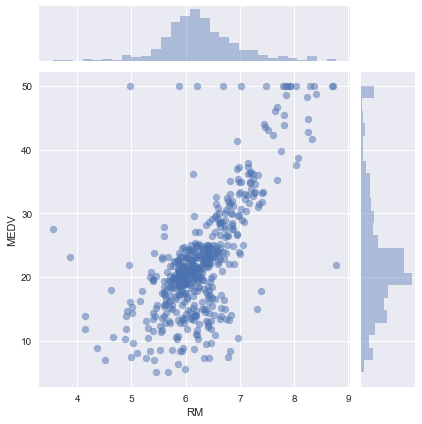

In [11]:
sns.jointplot(data["RM"], data["MEDV"], kind="scatter", joint_kws={"alpha":0.5});

Из диаграммы рассеяния хорошо видно, что имеет место положительная линейная связь между переменными RM и MEDV, то есть дома с большим числом комнат имеют более высокую цену.

In [12]:
data[["RM", "MEDV"]].describe()

,RM,MEDV
count,506.000000,506.000000
mean,6.284634,22.532806
std,0.702617,9.197104
min,3.561000,5.000000
25%,5.885500,17.025000
50%,6.208500,21.200000
75%,6.623500,25.000000
max,8.780000,50.000000


Также можем сделать следующие предположения:

16 наблюдений MEDV имеют значение 50.0. Скорее всего эти наблюдения содержали пропуски или не было возможности указать действительную цену дома, поэтому эти наблюдения могут быть исключены из набора данных.
одно наблюдение признака RM имеет значение 8.78. Это наблюдение может рассматриваться как выброс и может быть исключено из набора данных;
два наблюдения признака RM имеют значения меньше 4. Наблюдения можно рассматривать как выбросы и должны быть исключены из набора данных.
Итак, модель которую мы будем строить имеет следующий вид:

𝑀𝐸𝐷𝑉=𝜃0+𝜃1×𝑅𝑀

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [375]:
class GDRegressor:

    def __init__(self, alpha=0.01, n_iter=100, progress=True):
        self.alpha = alpha
        self.n_iter = n_iter
        self.disable = not progress
   
    def fit(self, X, y):
        x, Y = list(X), list(y)
        theta = [0.33] * 2
        m = len(y)
        grad = [0] * 2
        self.coef_h = []
        self.intercept_h = []
        self.loss_h = []
        for i in range(self.n_iter):
            self.coef_h.append(theta[1])
            self.intercept_h.append(theta[0])
            y_hyp = [theta[0] + theta[1] * x[j] for j in range(m)]

            grad[0] = 2 * sum([y_hyp[j] - Y[j] for j in range(m)]) / m
            grad[1] = 2 * sum([(y_hyp[j] - Y[j]) * x[j] for j in range(m)]) / m

            theta[0] -= self.alpha * grad[0]
            theta[1] -= self.alpha * grad[1]
            self.loss_h.append(sum([(y_hyp[j] - Y[j]) ** 2 for j in range(m)]) / m)
        self.coef_, self.intercept_ = theta[1], theta[0]
        return theta, grad

    def predict(self, X_test):
        X = list(X_test)
        prediction = []
        for i in range(len(X)):
            prediction.append(self.intercept_ + self.coef_ * X[i])
        return prediction

    def gradient_check(self, X_test, epsilon = 10e-7):
        theta = [self.intercept_, self.coef_]
        x = list(X_test)
        for th in theta:
            theta_plus = th + epsilon                               
            theta_minus = th - epsilon                             
            J_plus = np.dot(theta_plus, x)                 
            J_minus = np.dot(theta_minus, x)             
            gradapprox = (J_plus - J_minus) / (2 * epsilon)
            grad = x
            numerator = np.linalg.norm(grad - gradapprox)                 
            denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)   
            difference = numerator / denominator                              
            if difference < 1e-7:
                print("OK", difference)
            else:
                print("Not OK", difference)

In [347]:
X = data["RM"]
y = data["MEDV"]
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.0026, n_iter=20000)
%time model.fit(X_train, Y_train)

CPU times: user 3.65 s, sys: 23.6 ms, total: 3.67 s
Wall time: 3.7 s


([-25.423736349787816, 7.648416011442577],
 [0.2737136508408135, -0.04318077865923485])

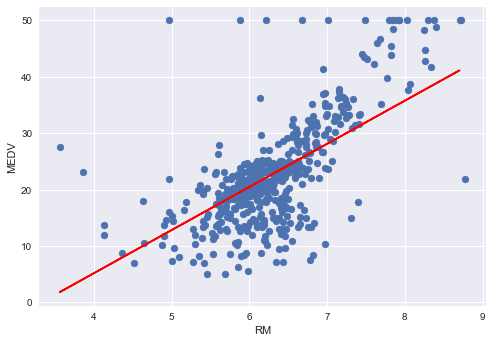

In [305]:
plt.scatter(data["RM"], data["MEDV"])
plt.xlabel("RM")
plt.ylabel("MEDV")
plt.plot(X_train, [model.coef_ * x + model.intercept_ for x in X_train], "r")
plt.show()

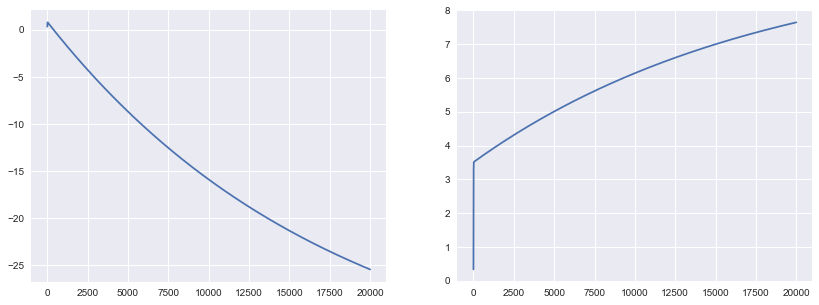

In [306]:
def plot_coeffs(model):
    plt.figure(figsize=(14, 5))
    plt.subplot(121)
    plt.plot(list(range(model.n_iter)), model.intercept_h)
    plt.subplot(122)
    plt.plot(list(range(model.n_iter)), model.coef_h)
plot_coeffs(model)

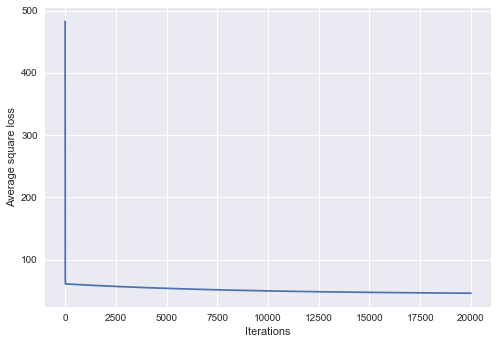

In [307]:
def plot_loss_function(model):
    plt.xlabel("Iterations")
    plt.ylabel("Average square loss")
    plt.plot(np.arange(model.n_iter), model.loss_h)
plot_loss_function(model)

In [308]:
def r_squared(y_hat, y):
    mean = np.mean(y)
    l1 = l2 = 0
    for i in range(len(y)):
        l1 += (list(y)[i] - y_hat[i]) ** 2
        l2 +=(list(y)[i] - mean) ** 2
    return (1 - (l1 / l2))
def rmse(y_hat, y):
    sum1 = sum([(y_hat[i] - list(y)[i]) ** 2 for i in range(len(list(y)))])
    return((sum1 / len(y)) ** 0.5)

In [309]:
Y_pred = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

(6.451098109820784, 0.49593769891708794)

In [310]:
X_filtered = data[(data["MEDV"] < 50)]["RM"]
y_filtered = data[(data["MEDV"] < 50)]["MEDV"]

In [376]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, y_filtered, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.02, n_iter=11000)
%time model.fit(X_train, Y_train)
theta = model.fit(X_train, Y_train)[0]
model.gradient_check(X_test)

CPU times: user 1.9 s, sys: 9.01 ms, total: 1.91 s
Wall time: 1.92 s
OK 6.818026294602529e-10
OK 1.3174024662180289e-10


In [352]:
Y_pred = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

(5.652215267147203, 0.5525856024900033)

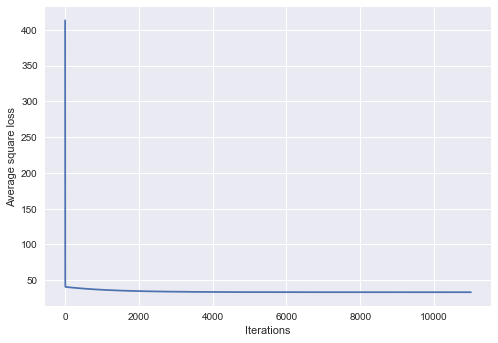

In [353]:
plot_loss_function(model)

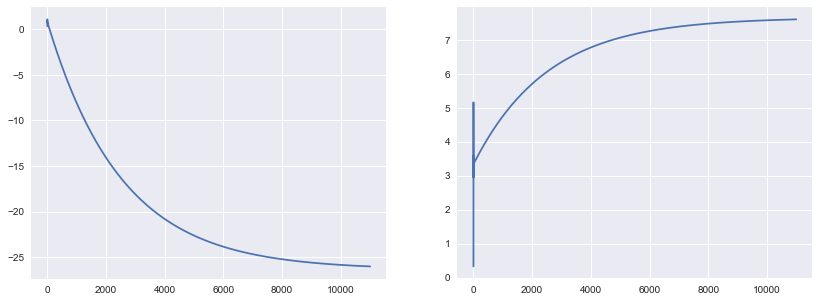

In [354]:
plot_coeffs(model)

In [355]:
def z_scaler(feature):
    std = np.std(feature)
    mean = np.mean(feature)
    z = []
    for i in range(len(feature)):
        z.append((feature[i] - mean) / std)
    return z

def min_max(feature):
    min_ = np.min(feature)
    max_ = np.max(feature)
    res = []
    for i in range(len(feature)):
        res.append((list(feature)[i] - min_) / (max_ - min_))
    return res
X_scaled = z_scaler(X)
y_scaled = z_scaler(y)

In [356]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.04, n_iter=300)
model.fit(X_train, Y_train)

([0.000271198625830615, 0.7373261146303378],
 [-1.841800024522343e-11, -1.6271701545471522e-10])

In [357]:
Y_pred = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

(0.7094504000497254, 0.48535937662883677)

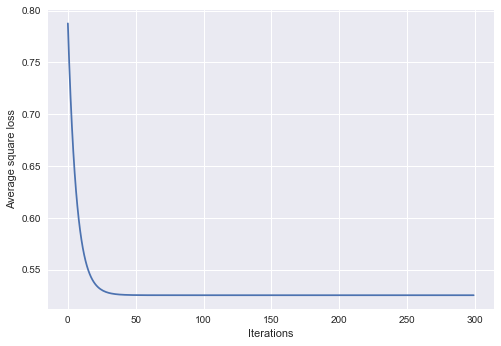

In [300]:
plt.xlabel("Iterations")
plt.ylabel("Average square loss")
plt.plot(np.arange(model.n_iter), model.loss_h);

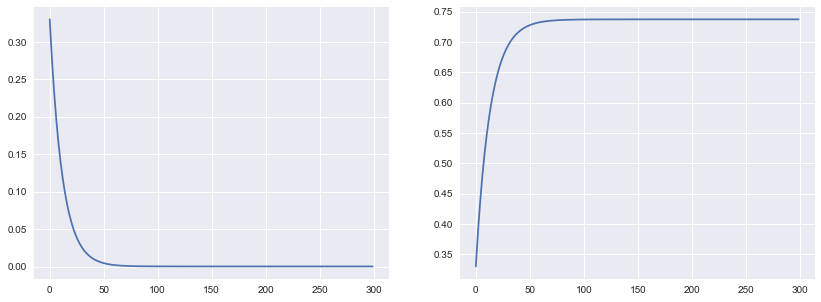

In [358]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(list(range(model.n_iter)), model.intercept_h)
plt.subplot(122)
plt.plot(list(range(model.n_iter)), model.coef_h);

# Mini-batch

In [445]:
from random import randint
class Mini_batch:

    def __init__(self, alpha=0.001, batch_size=10, n_epoch=10000, progress=True):
        self.alpha = alpha
        self.n_epoch = n_epoch
        self.bs = batch_size
        self.disable = not progress

    def fit(self, X, y, e=10e-4):
        self.cost_h = []
        theta = [0.33] * 2
        theta_old = [0] * 2
        x, Y = list(X), list(y)
        grad = [0] * 2
        for i in range(self.n_epoch):
            k = randint(0, len(y) - self.bs)
            m = len([x[j] for j in range(k, k+self.bs)])
            theta_old = theta
            y_hyp = [theta[0] + theta[1] * x[j] for j in range(m)]

            grad[0] = 2 * sum([y_hyp[j] - Y[j] for j in range(m)]) / m
            grad[1] = 2 * sum([(y_hyp[j] - Y[j]) * x[j] for j in range(m)]) / m

            theta[0] -= self.alpha * grad[0]
            theta[1] -= self.alpha * grad[1]
            self.cost_h.append(sum([(y_hyp[j] - Y[j]) ** 2 for j in range(m)]) / m)
        self.coef_, self.intercept_ = theta[1], theta[0]
        
    def predict(self, X_test):
        predictions = []
        for i in range(len(list(X_test))):
            predictions.append(self.coef_ * list(X_test)[i] + self.intercept_)
        self.predictions = predictions

In [443]:
model = Mini_batch(alpha=0.004, batch_size=100)
model.fit(X_train, Y_train)
model.coef_, model.intercept_

(6.402052035243544, -17.976008578492426)

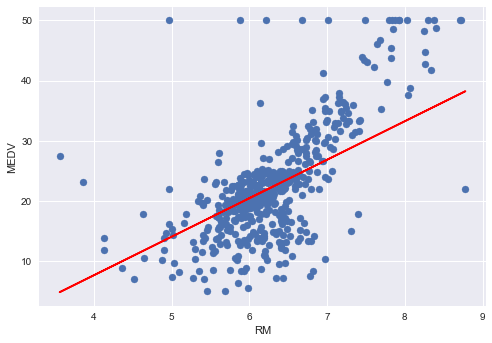

In [444]:
plt.scatter(data["RM"], data["MEDV"])
plt.xlabel("RM")
plt.ylabel("MEDV")
plt.plot(X_train, [model.coef_ * x + model.intercept_ for x in X_train], "r")
plt.show()

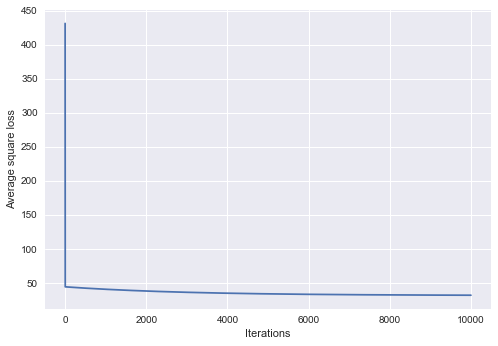

In [412]:
plt.xlabel("Iterations")
plt.ylabel("Average square loss")
plt.plot(np.arange(model.n_epoch), model.cost_h);

In [449]:
model = GDRegressor(alpha=0.0026, n_iter=20000)
train_sizes = [1, 10, 50, 100, 200, 401]
validation_scores_mean = []
train_scores_mean = []
for i in range(len(train_sizes)):
    size = train_sizes[i]
    model.fit(X_train[:size], Y_train[:size])
    Y_pred = model.predict(X_test)
    Y_train_pred = model.predict(X_train[:size])
    validation_scores_mean.append((rmse(Y_pred, Y_test))**2)
    train_scores_mean.append((rmse(Y_train_pred, Y_train[:size]))**2)

(0.0, 70.0)

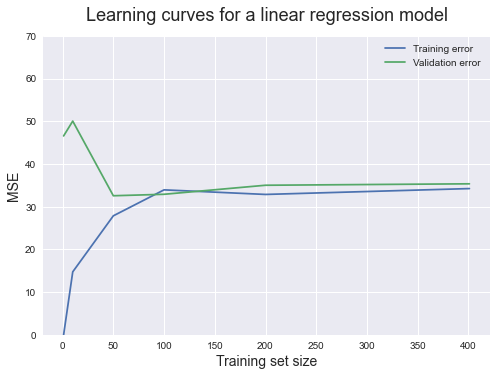

In [450]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,70)